In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [1]:
# Initialize population
def initialize_population(num_cities, population_size):
    return [np.random.permutation(num_cities) for _ in range(population_size)]


In [2]:
# Calculate total distance for a route
def calculate_total_distance(route, distance_matrix):
    return sum(distance_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)) + distance_matrix[route[-1], route[0]]


In [3]:
# Calculate total time for a route (for multi-objective, replace with your own logic)
def calculate_total_time(route, time_matrix):
    return sum(time_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)) + time_matrix[route[-1], route[0]]


In [4]:
# Evaluate the population fitness (considering multiple objectives)
def evaluate_population(population, distance_matrix, time_matrix):
    return [(calculate_total_distance(route, distance_matrix), calculate_total_time(route, time_matrix)) for route in population]


In [5]:
# Calculate crowding distance for each individual in the population
def calculate_crowding_distance(fitness):
    distance = np.zeros(len(fitness))
    sorted_fitness = sorted(fitness, key=lambda x: x[0])
    distance[0] = distance[-1] = float('inf')  # Ensure boundary solutions are always selected

    # Calculate crowding distance for each individual
    for i in range(1, len(fitness) - 1):
        distance[i] = (sorted_fitness[i + 1][0] - sorted_fitness[i - 1][0]) + (sorted_fitness[i + 1][1] - sorted_fitness[i - 1][1])

    return distance


In [6]:

# Update team solutions
def update_solution(team, best_solution, worst_solution, distance_matrix, time_matrix):
    new_population = []
    for route in team:
        new_route = route.copy()
        num_cities = len(route)

        for i in range(num_cities):
            if np.random.rand() < 0.5:
                new_route[i] = best_solution[i]
            elif np.random.rand() < 0.5:
                new_route[i] = worst_solution[i]

        # Ensure feasibility using swap operation
        for i in range(num_cities):
            if np.count_nonzero(new_route == new_route[i]) > 1:
                missing_cities = list(set(range(num_cities)) - set(new_route))
                new_route[i] = missing_cities[0]

        new_population.append(new_route)

    return new_population


In [7]:
# Split population into teams
def split_into_teams(population, num_teams):
    return np.array_split(population, num_teams)


In [8]:
# Generate random city coordinates
def generate_random_coordinates(num_cities, x_range=(0, 10), y_range=(0, 10)):
    return [(np.random.uniform(*x_range), np.random.uniform(*y_range)) for _ in range(num_cities)]


In [23]:
# Find the global best and worst solutions using Pareto dominance
def pareto_dominance(fitness1, fitness2):
    # Returns True if fitness1 dominates fitness2
    return (fitness1[0] <= fitness2[0] and fitness1[1] <= fitness2[1]) and (fitness1[0] < fitness2[0] or fitness1[1] < fitness2[1])

# AMTPG Jaya Algorithm with dynamic team adjustments and convergence
def amtpj_jaya_tsp(distance_matrix, time_matrix, num_teams=3, population_size=50, iterations=50, convergence_threshold=5):
    num_cities = len(distance_matrix)
    population = initialize_population(num_cities, population_size)
    teams = split_into_teams(population, num_teams)

    global_best_solution = None
    global_best_fitness = (float('inf'), float('inf'))  # (distance, time)

    all_best_routes = []  # Store best routes for each iteration
    all_best_distances = []  # Store best distances for each iteration
    all_best_times = []  # Store best times for each iteration

    stagnant_iterations = 0  # Count of iterations without improvement

    # Define evaluate_population function to calculate fitness for each route in a population
    def evaluate_population(population, distance_matrix, time_matrix):
        return [(calculate_total_distance(route, distance_matrix), calculate_total_time(route, time_matrix)) for route in population]

    for iteration in range(iterations):
        start_time = time.time()

        # Evaluate teams
        team_fitness = [evaluate_population(team, distance_matrix, time_matrix) for team in teams]

        # Find global best and worst solutions using Pareto dominance
        global_best_fitness_iteration = None
        global_best_solution = None

        for team in teams:
            for route in team:
                route_fitness = (calculate_total_distance(route, distance_matrix), calculate_total_time(route, time_matrix))

                if global_best_fitness_iteration is None or pareto_dominance(route_fitness, global_best_fitness_iteration):
                    global_best_solution = route
                    global_best_fitness_iteration = route_fitness

        # Update global best using Pareto dominance (considering both distance and time)
        if global_best_fitness_iteration is not None and (global_best_fitness_iteration[0] < global_best_fitness[0] or global_best_fitness_iteration[1] < global_best_fitness[1]):
            global_best_solution = global_best_solution
            global_best_fitness = global_best_fitness_iteration
            stagnant_iterations = 0  # Reset stagnant iterations
        else:
            stagnant_iterations += 1

        # Save the best route and fitness for this iteration
        all_best_routes.append(global_best_solution)
        all_best_distances.append(global_best_fitness_iteration[0])
        all_best_times.append(global_best_fitness_iteration[1])

        # Dynamic team adjustments: Replace underperforming teams
        team_qualities = [np.mean([fitness[0] for fitness in team_fitness]) for team_fitness in team_fitness]
        worst_team_index = np.argmax(team_qualities)  # Team with highest average fitness (worst)
        teams[worst_team_index] = initialize_population(num_cities, len(teams[worst_team_index]))

        # Update each team's solutions
        for i, team in enumerate(teams):
            teams[i] = update_solution(team, global_best_solution, teams[i][0], distance_matrix, time_matrix)

        end_time = time.time()

        # Print the path and distance for this iteration
        print(f"Iteration {iteration + 1}:")
        print(f"Global Best Path: {global_best_solution}")
        print(f"Global Best Distance: {global_best_fitness_iteration[0]}")
        print(f"Global Best Time: {global_best_fitness_iteration[1]}")
        print(f"Time Taken: {end_time - start_time:.4f} seconds\n")

        # Check for convergence
        if stagnant_iterations >= convergence_threshold:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break

    return global_best_solution, global_best_fitness, all_best_routes, all_best_distances, all_best_times

In [10]:

# Plot a route
def plot_route(route, cities_coordinates, title):
    # Extract the coordinates of the cities based on the route
    route_coordinates = [cities_coordinates[i] for i in route]

    # Add the starting city at the end of the route to close the loop
    route_coordinates.append(cities_coordinates[route[0]])

    # Unzip the list of coordinates into x and y lists
    x, y = zip(*route_coordinates)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'o-', label="Route")
    plt.scatter(x[0], y[0], color='red', label='Start/End', s=100)
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.show()


In [11]:

# Read distance matrix from a file
def read_distance_matrix(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    distance_matrix = []
    for line in lines:
        row = [float(value) for value in line.strip().split()]
        distance_matrix.append(row)
    size = len(distance_matrix)
    full_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(len(distance_matrix[i])):
            full_matrix[i, j] = distance_matrix[i][j]
            full_matrix[j, i] = distance_matrix[i][j]
    return full_matrix


Initial Best Route Before Optimization:
Route: [30  8 48 13 29 15 39 35 33 36 21  1 50 26 11 17  2 40 34 37  5  0 19  9
 22  6 46 42 28 14 51 23  4 32 20 38 43  7 18 41 44 25 16 31 45 24 52 49
 12  3 47 27 10]
Distance: 25213.0
Time: 25213.0
Iteration 1:
Global Best Path: [ 8 36 17 33 23 39  2 35 52 21 16 48  3 40 11 51 27  0 10 45 43  7 12 26
 13 47 24 42  5  6 37 29 34 19 50 15 46 31 18 22 44 30 25 32  4 41  9  1
 20 49 14 38 28]
Global Best Distance: 25457.0
Global Best Time: 25457.0
Time Taken: 0.0212 seconds

Iteration 2:
Global Best Path: [ 5 40  0 34 23 21  6  8 41  9 16 48 11 45 33 51 52 14 10 46 43  7 12 26
 13 47 18 15 49 36  4 29 50 19 38 24  2 17 37 27 44 30 25 32 20 35 39  1
 42 31  3 22 28]
Global Best Distance: 22692.0
Global Best Time: 22692.0
Time Taken: 0.0241 seconds

Iteration 3:
Global Best Path: [ 5 33  0 34 23 21  6  4  3 39 41 48  8 40 11 51 52 42 10 46 43  7 12 26
 13 47 18 15 16 36 45 29 50 19 24 22  2 17 37 27 44 30 25 32 31 35  9  1
 20 49 14 38 28]
Global B

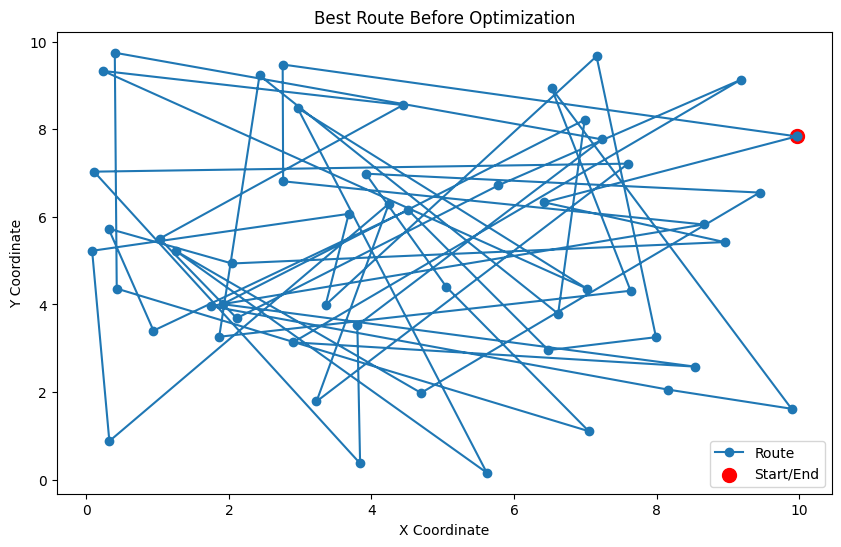

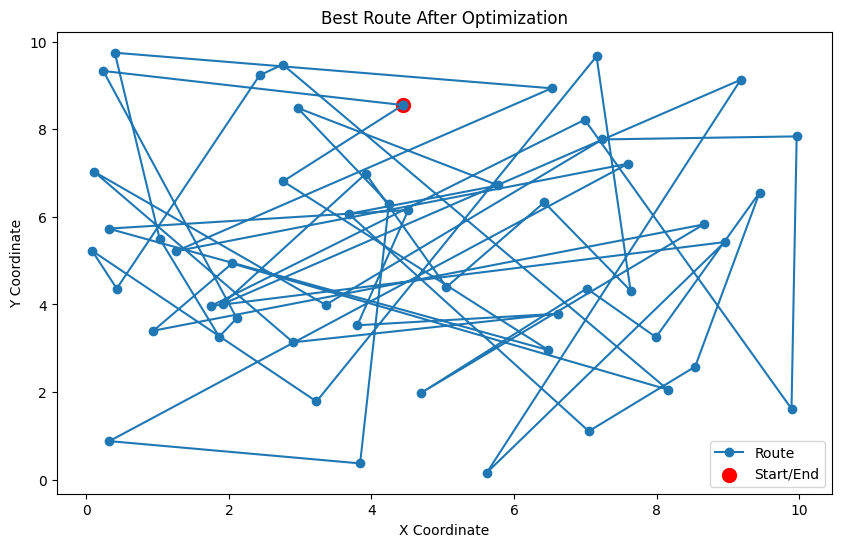

In [29]:
# Example Usage
file_path = 'cities.txt'
distance_matrix = read_distance_matrix(file_path)
time_matrix = read_distance_matrix(file_path)  # Assuming time matrix is the same, modify if different

# Generate random city coordinates (just an example)
cities_coordinates = generate_random_coordinates(len(distance_matrix))

# Find the initial best route before optimization
initial_population = initialize_population(len(distance_matrix), 50)
initial_best_route = min(initial_population, key=lambda route: calculate_total_distance(route, distance_matrix))

# Calculate the distance and time for the initial best route
initial_best_distance = calculate_total_distance(initial_best_route, distance_matrix)
initial_best_time = calculate_total_time(initial_best_route, time_matrix)

# Print the initial best route, distance, and time before optimization
print("Initial Best Route Before Optimization:")
print("Route:", initial_best_route)
print("Distance:", initial_best_distance)
print("Time:", initial_best_time)

# Solve the TSP using the AMTPG Jaya Algorithm
best_route, best_fitness, all_best_routes, all_best_distances, all_best_times = amtpj_jaya_tsp(distance_matrix, time_matrix, num_teams=3, iterations=50, convergence_threshold=5)

# Print final results after optimization
print("\nBest Route After Optimization:")
print("Route:", best_route)
print("Best Distance:", best_fitness[0])
print("Best Time:", best_fitness[1])

# Plot the Best Route before Optimization
plot_route(initial_best_route, cities_coordinates, "Best Route Before Optimization")

# Plot the Best Route after Optimization
plot_route(best_route, cities_coordinates, "Best Route After Optimization")
